In [1]:
import sys
sys.path.append('../../../') # Add the root directory to sys.path

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

In [3]:
test_dir = '../../../data/Gaia DR3/test.parquet'
data = pd.read_parquet(test_dir)
data

,source_id,teff_gspphot,logg_gspphot,mh_gspphot,spectraltype_esphs,Cat,flux
0,2270162933477596928,5793.526855,4.2239,-0.2202,F,LM,"[2.1406083e-17, 1.36527624e-17, 8.9983064e-18,..."
1,5595563490086213760,16123.186523,4.1203,-0.9216,B,LM,"[5.743483e-16, 5.6371223e-16, 5.316359e-16, 5...."
2,2062156877074076544,33753.062500,4.1338,-0.9648,B,M,"[9.540365e-16, 9.370028e-16, 8.942922e-16, 8.6..."
3,2266614878173081216,6153.653809,4.0231,-0.6670,F,LM,"[4.3227304e-17, 3.599028e-17, 3.1161376e-17, 3..."
4,2005083633660968704,16388.207031,3.7014,-0.0590,B,M,"[1.1341707e-15, 1.1049582e-15, 1.0222559e-15, ..."
...,...,...,...,...,...,...,...
3521,2263579951202517120,5750.221191,4.2642,-0.1881,G,LM,"[2.4816538e-17, 2.2245785e-17, 2.0786124e-17, ..."
3522,4094753787724436480,17691.224609,3.3499,0.2152,B,M,"[2.1005067e-14, 2.1114124e-14, 1.9657805e-14, ..."
3523,2268895780684642048,5785.978027,4.1548,-0.1405,G,LM,"[4.950771e-17, 4.735013e-17, 4.7743644e-17, 4...."
3524,5524705188351695744,22477.400391,3.7834,0.0073,B,M,"[4.0475476e-14, 4.102307e-14, 3.6672142e-14, 3..."


In [4]:
df = data.drop(columns = ['teff_gspphot', 'logg_gspphot', 'mh_gspphot', 'spectraltype_esphs'])[:1000]
df.head()

,source_id,Cat,flux
0,2270162933477596928,LM,"[2.1406083e-17, 1.36527624e-17, 8.9983064e-18,..."
1,5595563490086213760,LM,"[5.743483e-16, 5.6371223e-16, 5.316359e-16, 5...."
2,2062156877074076544,M,"[9.540365e-16, 9.370028e-16, 8.942922e-16, 8.6..."
3,2266614878173081216,LM,"[4.3227304e-17, 3.599028e-17, 3.1161376e-17, 3..."
4,2005083633660968704,M,"[1.1341707e-15, 1.1049582e-15, 1.0222559e-15, ..."


In [5]:
df['min'] = df['flux'].apply(np.min)
df['max'] = df['flux'].apply(np.max)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  1000 non-null   int64  
 1   Cat        1000 non-null   object 
 2   flux       1000 non-null   object 
 3   min        1000 non-null   float32
 4   max        1000 non-null   float32
dtypes: float32(2), int64(1), object(2)
memory usage: 31.4+ KB


In [7]:
df.describe()

,source_id,min,max
count,1.000000e+03,1.000000e+03,1.000000e+03
mean,3.747249e+18,1.054663e-15,1.932106e-14
std,1.930569e+18,4.926419e-15,1.213815e-13
min,4.941553e+16,-5.084663e-18,2.935489e-17
25%,2.264732e+18,1.331727e-17,6.875591e-17
50%,3.044867e+18,5.728638e-17,2.649301e-16
75%,5.912580e+18,4.288882e-16,2.132412e-15
max,6.879651e+18,9.046429e-14,1.733219e-12


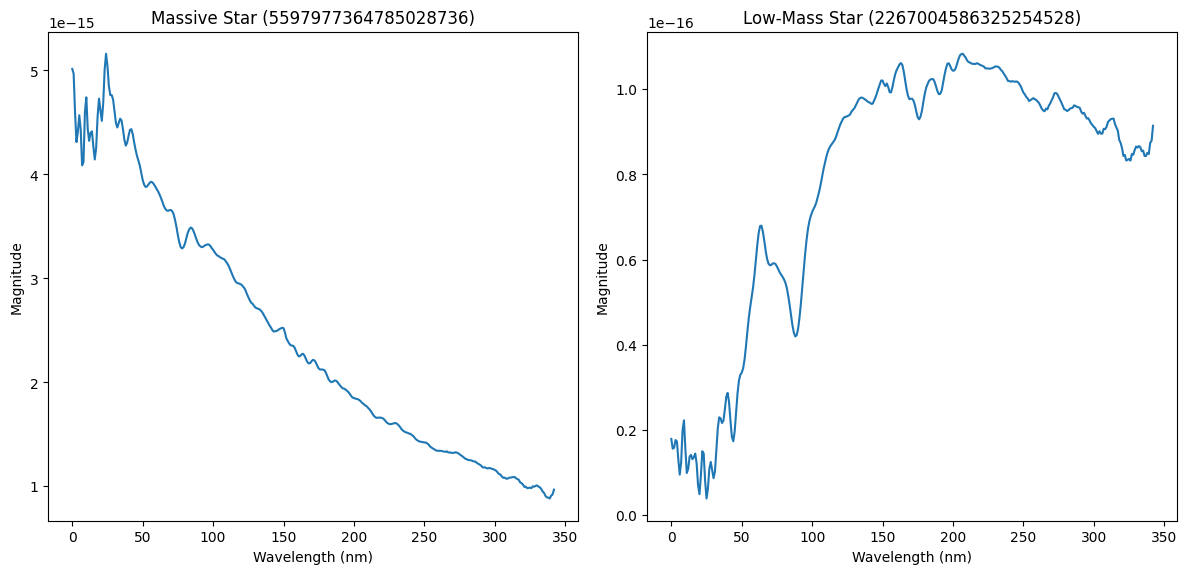

In [8]:
# rerun this cell to see random examples of different spectra


# Random sample from 'M' category (massive star)
sample_ms = df[df['Cat'] == 'M'].sample(n=1).index
flux_ms = df['flux'].iloc[sample_ms].values[0]
object_id_ms = df['source_id'].iloc[sample_ms].values[0]

# Random sample from 'LM' category (low-mass star)
sample_lm = df[df['Cat'] == 'LM'].sample(n=1).index
flux_lm = df['flux'].iloc[sample_lm].values[0]
object_id_lm = df['source_id'].iloc[sample_lm].values[0]

plt.figure(figsize=(12, 6))

# Plot for 'M' category (massive star)
plt.subplot(1, 2, 1)
plt.plot(flux_ms)
plt.title(f"Massive Star ({object_id_ms})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

# Plot for 'LM' category (low-mass star)
plt.subplot(1, 2, 2)
plt.plot(flux_lm)
plt.title(f"Low-Mass Star ({object_id_lm})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [9]:
num_samples = df.shape[0]
spectrum_width = len(df['flux'][0])

num_samples_lm = df['Cat'].value_counts()['LM']
num_samples_m = df['Cat'].value_counts()['M']
num_classes = df['Cat'].nunique()

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)
print("In the dataset, we have", num_samples_lm, "spectra for low mass stars and", num_samples_m, "spectra for high mass stars.")

Number of total spectral samples: 1000
Number of bins in each spectra: 343
In the dataset, we have 626 spectra for low mass stars and 374 spectra for high mass stars.


In [10]:
spectra = df['flux'].to_numpy()
context = df[['max','min']].to_numpy()
y = df['Cat'].to_numpy()

# encode categories to int
y = torch.from_numpy(np.where(y == 'M', 1, np.where(y == 'LM', 0, y)).astype(float))

# L2 normalization
spectra = torch.from_numpy(np.array([spectrum / np.linalg.norm(spectrum, keepdims=True) for spectrum in spectra])).float()

context = torch.tensor(context)

# combine training data
X = torch.cat([spectra,context],1)

In [11]:
def predict(model, X, y, verbose=True):
    
    # hyperparameters
    device = 'cuda'
    
    for m in model:
        # move everything to gpu
        m.to(device)
        X = X.to(device)
        y = y.to(device).unsqueeze(1)
        
        # metrics
        accuracy = 0

        m.eval()
        preds, probs = [], []

        with torch.no_grad():
            
            x_spectra = X[:,:-2]
            x_context = X[:,-2:]
            output = m(x_spectra.unsqueeze(1), x_context)

            prob = torch.sigmoid(output)
            pred = torch.round(prob).cpu().numpy().astype(float)  # pred: [batch_size]
            
            preds.extend(pred)
            probs.extend(prob.cpu().numpy())

        accuracy = accuracy_score(y.cpu().numpy(), preds)
        ra_score = roc_auc_score(y.cpu().numpy(), probs)
        f1 = f1_score(y.cpu().numpy(), preds)
        cm = confusion_matrix(y.cpu().numpy(), preds)
        
        return accuracy, ra_score, f1, cm

In [ ]:
model = torch.load('../../trained_models/test_model_ensemble.pth')

accuracy, auc_score, f1_score, cm = predict(model, X, y)

Accuracy: 0.97
AUC score: 0.99
F1 score: 0.96


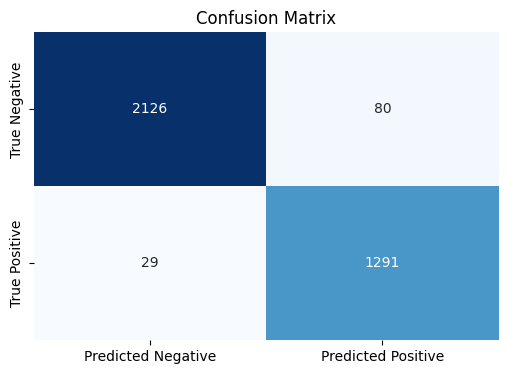

In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC score: {auc_score:.2f}")
print(f"F1 score: {f1_score:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix')
plt.show()